# Identificar los tramos diarios de temperaturas máximas y mínimas

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle

In [3]:
RANGE_VISUALIZ = [35.0, 38.0] # Rango de temperaturas para la visualización

fecha_ref = pd.Timestamp('2025-01-01 00:00:00').floor('h') # Para alinear las gráficas

In [4]:
with open("../procData/muestras_ovul_horas_norm1.pkl", "rb") as f:
    muestras_ovul_horas = pickle.load(f)

In [5]:
todas_series = []

for key, datos in muestras_ovul_horas.items():
    df = datos["serie"].copy()
    todas_series.append(df[["resultTimestamp", "result"]])

df_todas = pd.concat(todas_series)
resumen_orig = df_todas.groupby("resultTimestamp").agg(["mean", "std"]).reset_index()
resumen_orig.columns = ["resultTimestamp", "mean", "std"]


### Intervalo de temperaturas máximas

In [ ]:
intervalo_max = [21,3] # Ambos extremos incluidos, es decir, de 21:00 a 3:59

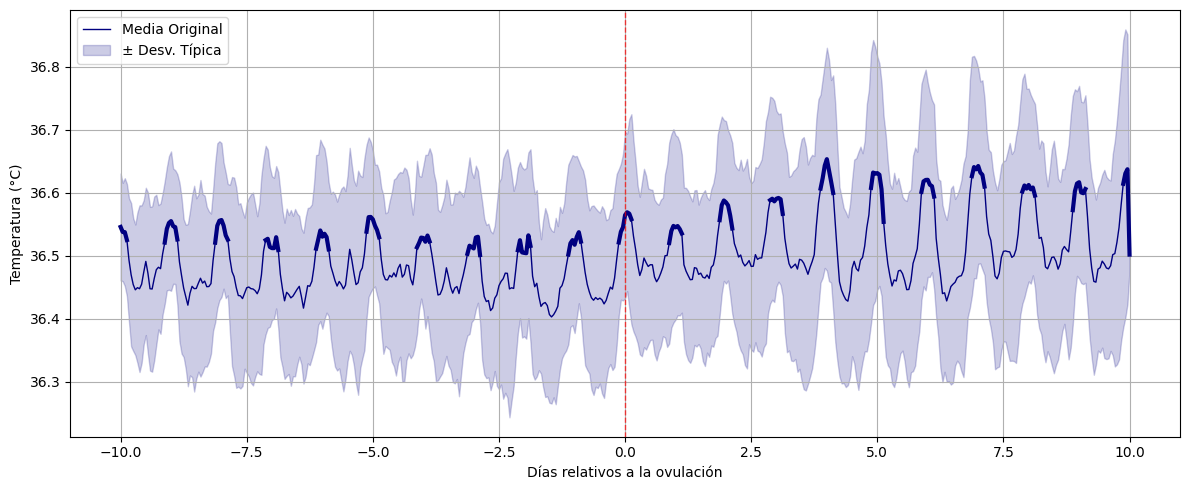

In [9]:
# Asegurarse de que 'resultTimestamp' es datetime
resumen_orig["resultTimestamp"] = pd.to_datetime(resumen_orig["resultTimestamp"])

# Crear figura
plt.figure(figsize=(12, 5))

# Línea base fina (todo el día)
plt.plot(
    (resumen_orig["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1),
    resumen_orig["mean"],
    label="Media Original",
    color="navy",
    linewidth=1
)

# Añadir columna de hora si no existe
resumen_orig["hour"] = resumen_orig["resultTimestamp"].dt.hour

# Definir intervalo nocturno si no está definido (ejemplo: de 22h a 6h)
# intervalo_max = (22, 6)  # Descomenta o ajusta si es necesario

# Filtrar horas nocturnas (dos tramos: >= intervalo_max[0] o <= intervalo_max[1])
mask_nocturno = (resumen_orig["hour"] >= intervalo_max[0]) | (resumen_orig["hour"] <= intervalo_max[1])
resumen_nocturno = resumen_orig[mask_nocturno].copy()

# Detectar tramos discontinuos (saltos de más de 1.5h)
resumen_nocturno["delta"] = resumen_nocturno["resultTimestamp"].diff().dt.total_seconds().div(3600)
resumen_nocturno["grupo"] = (resumen_nocturno["delta"] > 1.5).cumsum()

# Dibujar cada grupo nocturno como un tramo independiente
for _, grupo_df in resumen_nocturno.groupby("grupo"):
    plt.plot(
        (grupo_df["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1),
        grupo_df["mean"],
        color="navy",
        linewidth=3
    )

# Banda de ±1 desviación típica (todo el día)
plt.fill_between(
    (resumen_orig["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1),
    resumen_orig["mean"] - resumen_orig["std"],
    resumen_orig["mean"] + resumen_orig["std"],
    color="navy", alpha=0.2, label="± Desv. Típica"
)

# Línea vertical en la fecha de ovulación
plt.axvline(x=0, color="red", linestyle="--", linewidth=1, alpha=0.7)

# Etiquetas y diseño
plt.title("")
plt.xlabel("Días relativos a la ovulación")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Intervalo de temperaturas mínimas

In [7]:
intervalo_min = [7,15]

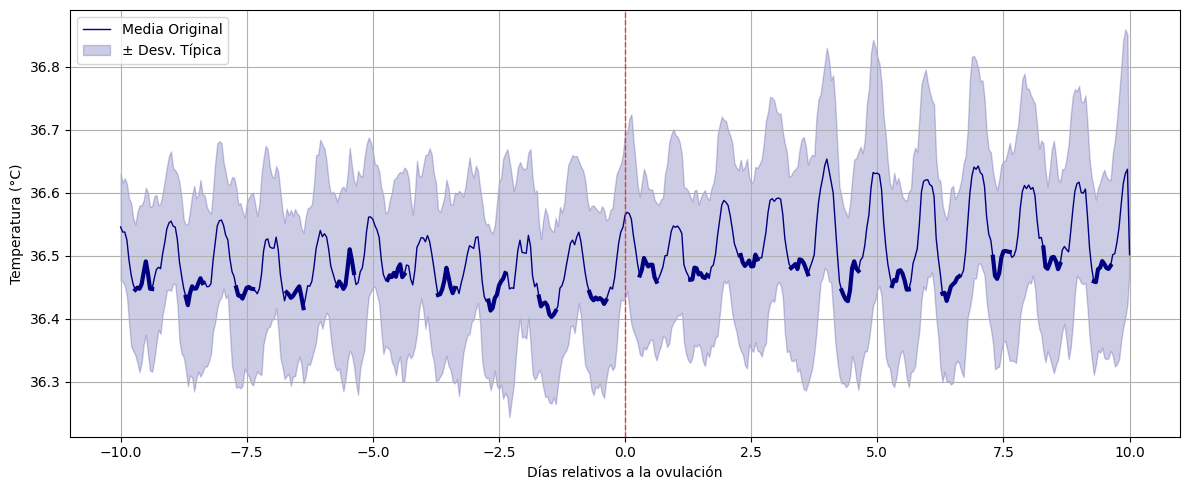

In [14]:
resumen_orig["resultTimestamp"] = pd.to_datetime(resumen_orig["resultTimestamp"])

# Crear figura
plt.figure(figsize=(12, 5))

# Línea base fina (todo el día)
plt.plot(
    (resumen_orig["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1),
    resumen_orig["mean"],
    label="Media Original",
    color="navy",
    linewidth=1
)

resumen_orig["hour"] = resumen_orig["resultTimestamp"].dt.hour

mask_diurno = resumen_orig["hour"].between(intervalo_min[0], intervalo_min[1])
resumen_diurno = resumen_orig[mask_diurno].copy()

# Detectar saltos grandes entre puntos
resumen_diurno["delta"] = resumen_diurno["resultTimestamp"].diff().dt.total_seconds().div(3600)
resumen_diurno["grupo"] = (resumen_diurno["delta"] > 1.5).cumsum()

# Dibujar cada grupo sin unir puntos lejanos
for _, grupo_df in resumen_diurno.groupby("grupo"):
    plt.plot(
        (grupo_df["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1),
        grupo_df["mean"],
        color="navy",
        linewidth=3
    )

# Banda de ±1 desviación típica (completa)
plt.fill_between(
    (resumen_orig["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1),
    resumen_orig["mean"] - resumen_orig["std"],
    resumen_orig["mean"] + resumen_orig["std"],
    color="navy", alpha=0.2, label="± Desv. Típica"
)

# Línea de ovulación
plt.axvline(x=0, color="red", linestyle="--", linewidth=1, alpha=0.7)

# Etiquetas y diseño
plt.title("")
plt.xlabel("Días relativos a la ovulación")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
